# Author: Morgan Reilly - G00303598

## References:

* https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/index.html?index=..%2F..index#0

* http://neuralnetworksanddeeplearning.com/chap1.html

* https://keras.io/

* https://www.ics.uci.edu/~mohamadt/keras_mnist.html


### Imports

In [1]:
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.utils import np_utils
from keras.regularizers import l2

from matplotlib import pyplot as plt
%matplotlib inline

print("Keras Version " + keras.__version__)

Using TensorFlow backend.
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)

Keras Version 2.3.1


### Load Data Set

In [2]:
# Loading data from training and test sets along with labels
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Print data
print("Original X Shape", X_train.shape)
print("Original Y Shape", Y_train.shape)

# Reshaping data
X_train = X_train.reshape(60000, 784) # Reshaping training data
X_test = X_test.reshape(10000, 784) # Reshaping test data

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255 # Original data is uint8 (0-255). Scale to range [0,1]
X_test /= 255

print("Training X Matrix Shape", X_train.shape)
print("Training X Matrix Shape", X_test.shape)

# print (Y_train[0])

# Represent the targets as one-hot vectors i.e 3 --> [0,0,0,0,1,0,0,0,0]
nb_classes = 10

Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)

print("Training Y matrix shape", Y_train.shape)
print("Testing Y matrix shape", Y_test.shape)

Original X Shape (60000, 28, 28)
Original Y Shape (60000,)
Training X Matrix Shape (60000, 784)
Training X Matrix Shape (10000, 784)
Training Y matrix shape (60000, 10)
Testing Y matrix shape (10000, 10)


### Viewing data

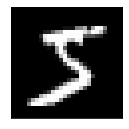

In [3]:
# Plot some of the data
plt.figure(1, figsize=(14, 3))

for i in range (1):
    plt.subplot(1, 6, 1+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

### Sequentail Keras Model

#### Notes:
Adding more layers to allow the network to go deeper.

Chaging 'sigmoid' to 'relu', reason being that even if the gradients coming from some neurons can be zero, there will always be others giving a clear non-zero gradient and training can continue at a good pace.

Changing 'sgd' to 'adam' --> Better optimizer

Adding dropout after each dense layer. Regularization technique.

In [4]:
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(784,), W_regularizer=l2(0.001)))
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 60)                6060      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                610       
Total params: 183,770
Trainable params: 183,770
Non-trainable params: 0
_________________________________________________________________


/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", input_shape=(784,), kernel_regularizer=<keras.reg...)`
  


### Train the model

In [5]:
history = model.fit(X_train, Y_train, batch_size=128, nb_epoch=10, verbose=1,
                    validation_data=(X_test, Y_test))

/home/morgan/GMIT/modules/Emerging_Tech/ET_PROJECT_2019/etp_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 45us/step - loss: 0.4750 - accuracy: 0.9129 - val_loss: 0.3506 - val_accuracy: 0.9432
Epoch 2/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.3920 - accuracy: 0.9331 - val_loss: 0.3803 - val_accuracy: 0.9368
Epoch 3/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.3430 - accuracy: 0.9423 - val_loss: 0.3575 - val_accuracy: 0.9365
Epoch 4/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.3317 - accuracy: 0.9431 - val_loss: 0.3289 - val_accuracy: 0.9427
Epoch 5/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.3229 - accuracy: 0.9441 - val_loss: 0.3108 - val_accuracy: 0.9442
Epoch 6/10
60000/60000 [==============================] - 3s 43us/step - loss: 0.3164 - accuracy: 0.9445 - val_loss: 0.3037 - val_accuracy: 0.9483
Epoch 7/10
60000/60000 [==============================] - 2s 39us/s

### Visualising predictions

KeyError: 'val_acc'

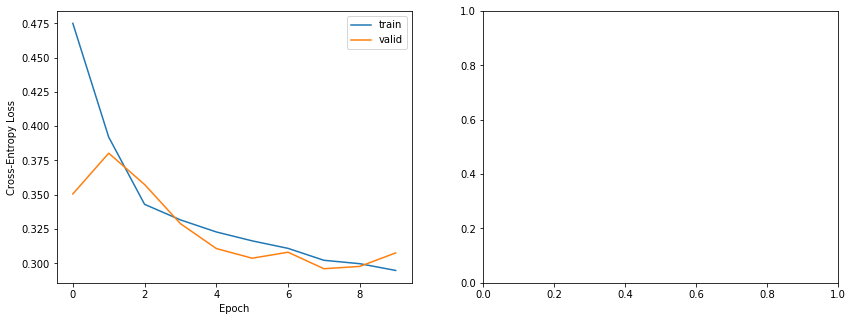

In [7]:
# Plot loss trajectory throughout training.
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_acc'], label='train')
plt.plot(history.history['val_acc'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()